In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 4.5703345390527765
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 729.19it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 544.83it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 515.22it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
    regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log_val.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### Exact Method 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, warmstart=True, conecheck=True)

In [13]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9978, Train Regret:  12.8715%, Val Regret:  12.4236%
Epoch   2, Loss:  -0.9992, Train Regret:   2.9000%, Val Regret:   3.5813%
Epoch   4, Loss:  -1.0000, Train Regret:   2.0042%, Val Regret:   2.6490%
Epoch   6, Loss:  -1.0000, Train Regret:   1.2965%, Val Regret:   1.9441%
Epoch   8, Loss:  -1.0000, Train Regret:   1.2239%, Val Regret:   1.6270%
Epoch  10, Loss:  -1.0000, Train Regret:   1.0652%, Val Regret:   1.4140%
Epoch  12, Loss:  -0.9999, Train Regret:   0.9501%, Val Regret:   1.3241%
Epoch  14, Loss:  -1.0000, Train Regret:   0.9341%, Val Regret:   1.2161%
Epoch  16, Loss:  -1.0000, Train Regret:   0.8335%, Val Regret:   1.1907%
Epoch  18, Loss:  -1.0000, Train Regret:   0.7998%, Val Regret:   0.9386%
Elapsed Time: 80.25 Sec


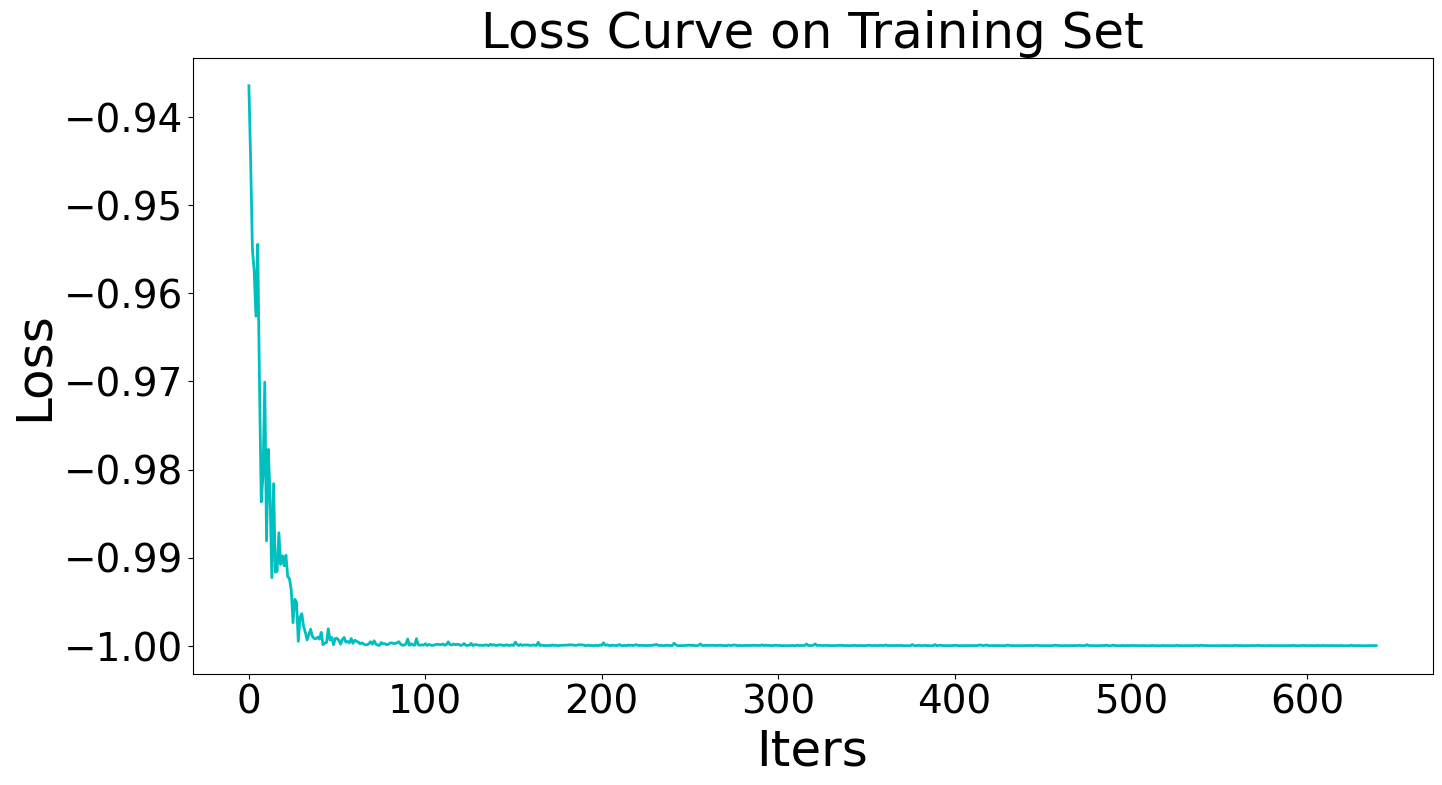

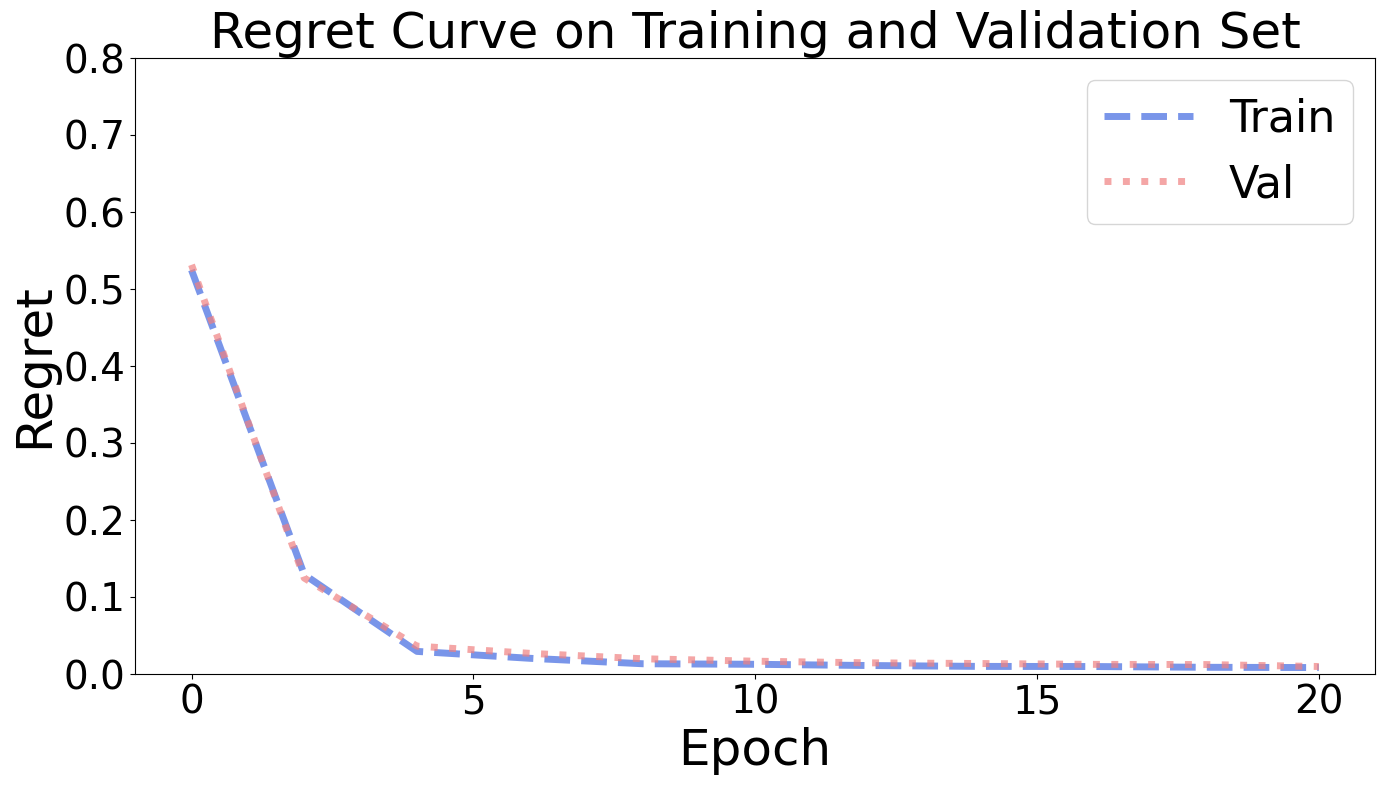

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel, conecheck=False)

In [17]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9969, Train Regret:  14.9699%, Val Regret:  12.7391%
Epoch   2, Loss:  -0.9998, Train Regret:   3.4869%, Val Regret:   4.1026%
Epoch   4, Loss:  -1.0000, Train Regret:   2.3195%, Val Regret:   2.7715%
Epoch   6, Loss:  -1.0000, Train Regret:   1.8150%, Val Regret:   1.9016%
Epoch   8, Loss:  -1.0000, Train Regret:   1.5158%, Val Regret:   1.5053%
Epoch  10, Loss:  -1.0000, Train Regret:   1.2670%, Val Regret:   1.3752%
Epoch  12, Loss:  -1.0000, Train Regret:   1.0142%, Val Regret:   1.1831%
Epoch  14, Loss:  -1.0000, Train Regret:   0.8860%, Val Regret:   0.9856%
Epoch  16, Loss:  -0.9998, Train Regret:   0.8923%, Val Regret:   0.9454%
Epoch  18, Loss:  -1.0000, Train Regret:   0.7983%, Val Regret:   0.9388%
Elapsed Time: 12.18 Sec


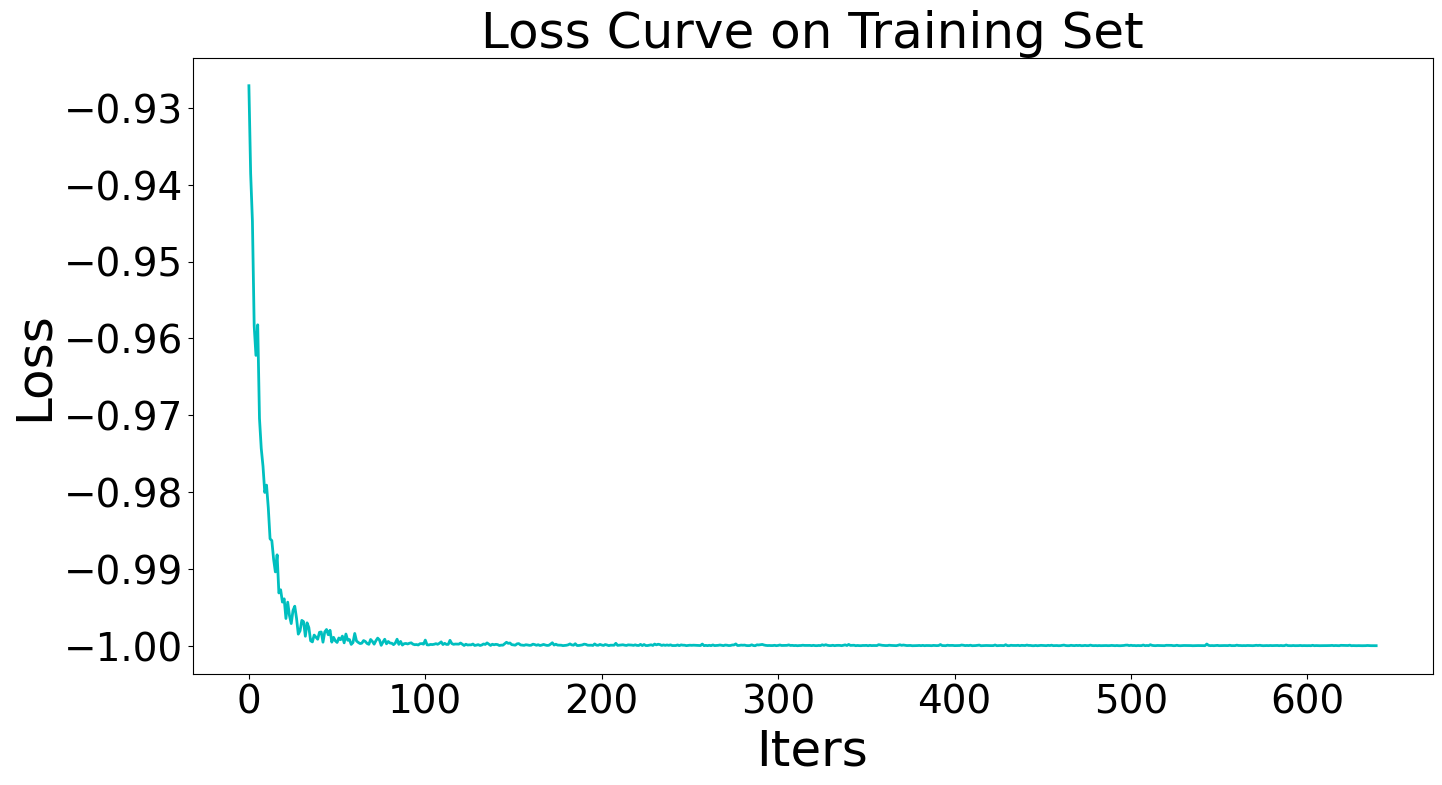

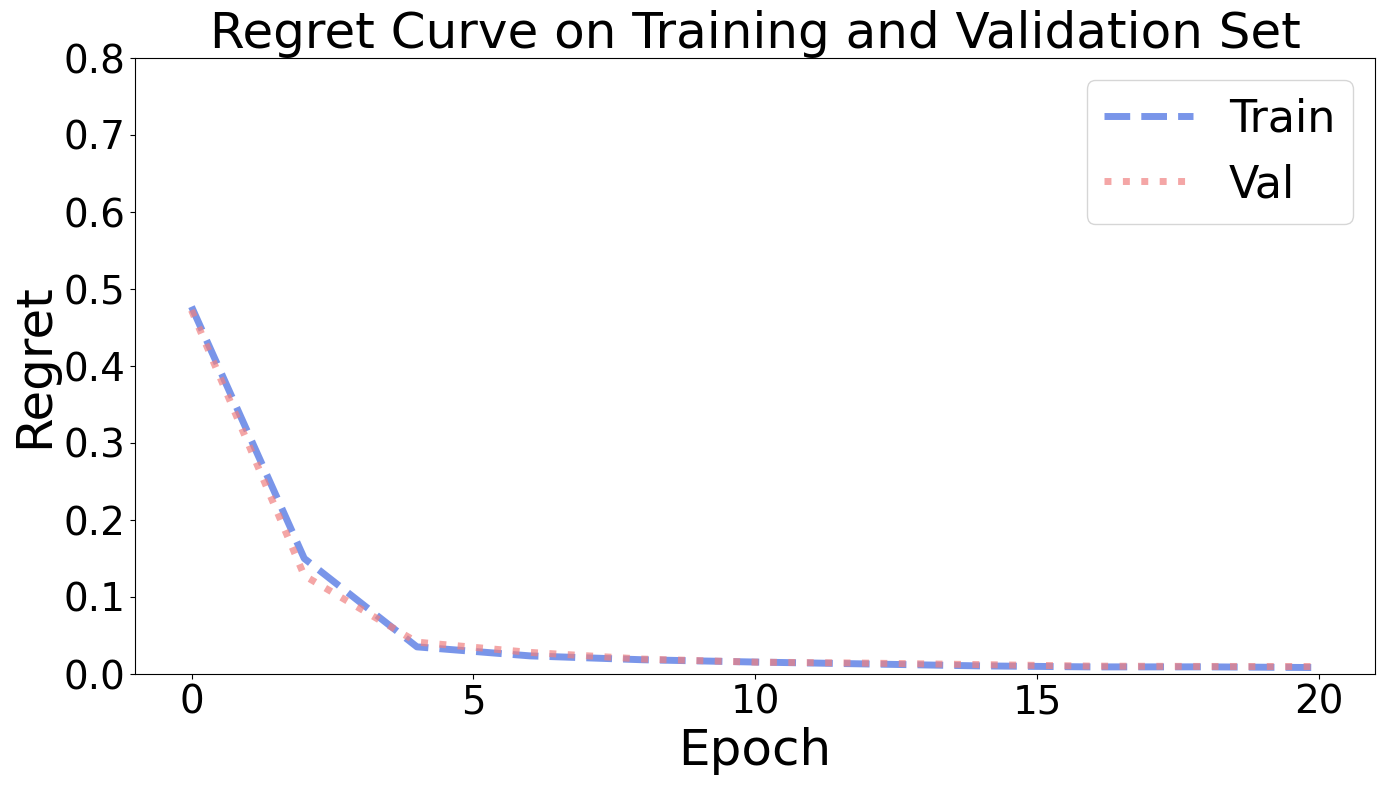

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Base Vector Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from pyepo import EPO
from pyepo.model.opt import optModel

from func import abstractConeAlignedCosine

class baseVectConeAlignedCosine(abstractConeAlignedCosine):
    """
    A autograd module to align cone and vector cosine similarity loss via base vectors
    """
    def _calLoss(self, pred_cost, tight_ctrs, optmodel):
        """
        A method to calculate loss
        """
        # get device
        device = pred_cost.device
        # get batch size
        batch_size = len(pred_cost)
        # init loss
        loss = torch.empty(batch_size).to(device)
        # cost vectors direction
        if optmodel.modelSense == EPO.MINIMIZE:
            # minimize
            pred_cost = - pred_cost
        # calculate cosine similarity
        cos_sim = F.cosine_similarity(pred_cost.unsqueeze(1), tight_ctrs, dim=2)
        # get max cosine similarity for each sample
        max_cos_sim, _ = torch.max(cos_sim, dim=1)
        loss = - max_cos_sim
        return loss

# init loss
ca_cos = baseVectConeAlignedCosine(optmodel)

In [21]:
lr = 5e-3
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.5556, Train Regret:  52.5975%, Val Regret:  51.1066%
Epoch   2, Loss:  -0.7583, Train Regret:  44.8996%, Val Regret:  42.6129%
Epoch   4, Loss:  -0.8452, Train Regret:  42.3434%, Val Regret:  39.6506%
Epoch   6, Loss:  -0.8468, Train Regret:  51.2567%, Val Regret:  48.6589%
Epoch   8, Loss:  -0.8654, Train Regret:  47.0884%, Val Regret:  43.9236%
Epoch  10, Loss:  -0.8636, Train Regret:  42.9329%, Val Regret:  41.8998%
Epoch  12, Loss:  -0.8281, Train Regret:  44.4005%, Val Regret:  44.0861%
Epoch  14, Loss:  -0.8508, Train Regret:  43.6103%, Val Regret:  45.5836%
Epoch  16, Loss:  -0.9638, Train Regret:  41.2574%, Val Regret:  38.6815%
Epoch  18, Loss:  -0.9788, Train Regret:  44.3507%, Val Regret:  43.0671%
Elapsed Time: 1.36 Sec


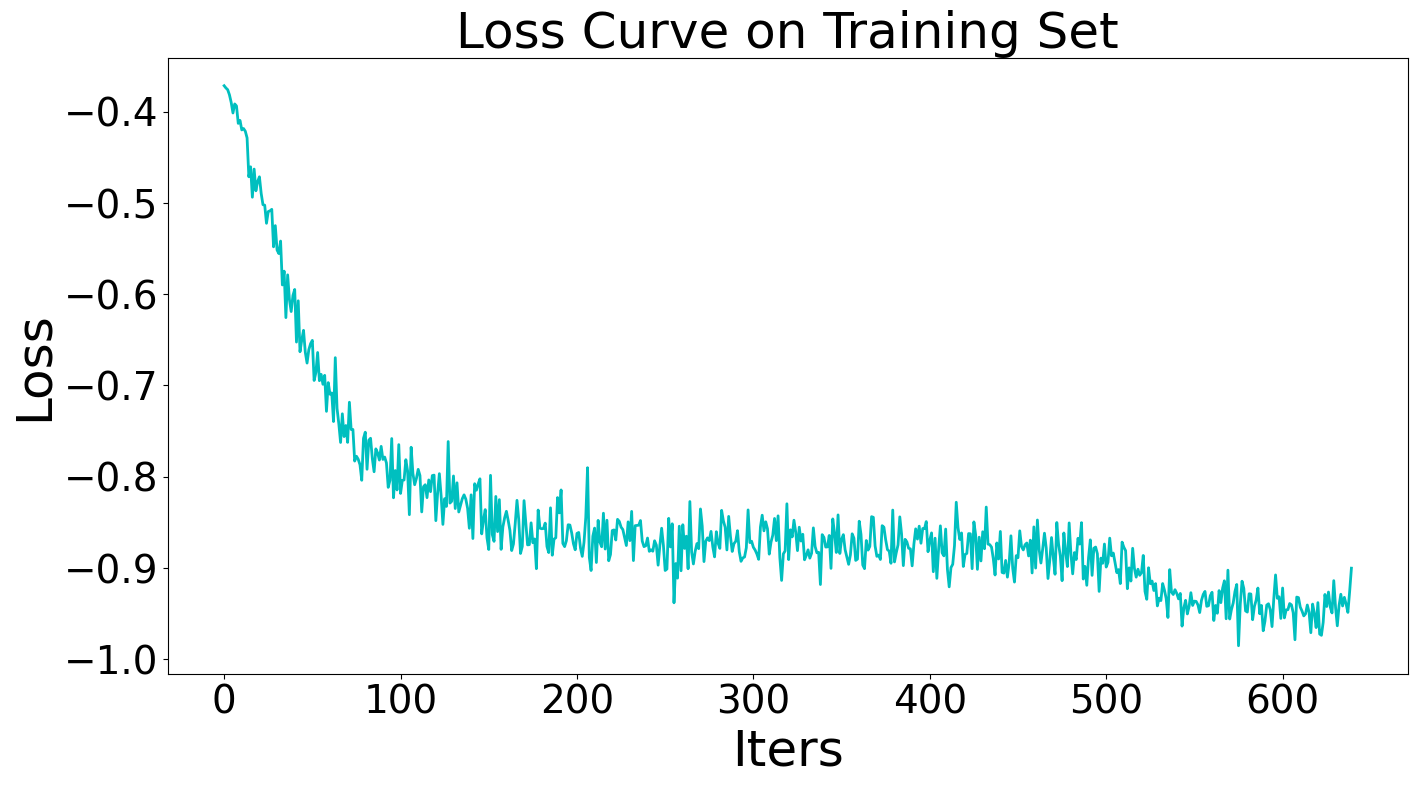

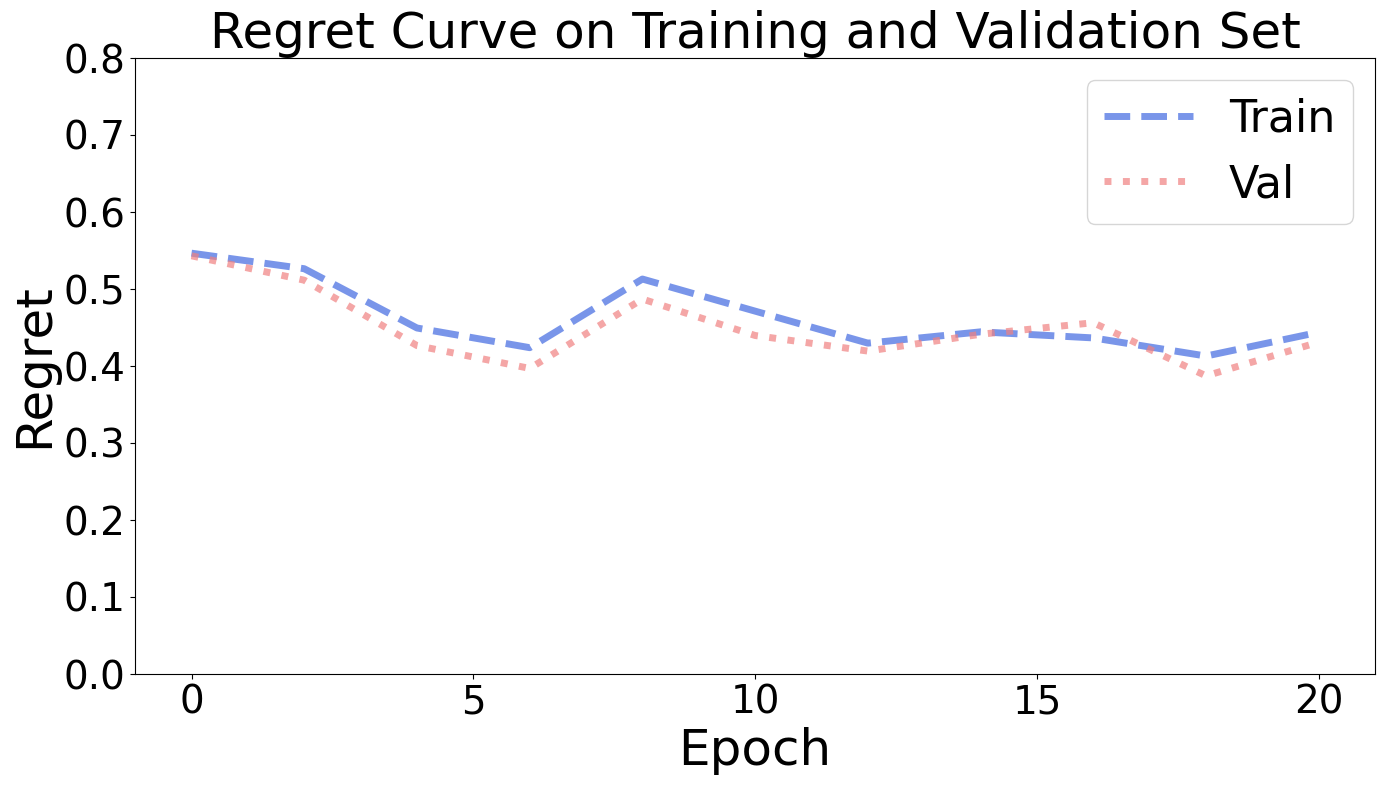

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Vector Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from pyepo import EPO
from pyepo.model.opt import optModel

from func import abstractConeAlignedCosine

class avgVectConeAlignedCosine(abstractConeAlignedCosine):
    """
    A autograd module to align cone and vector cosine similarity loss via average base vectors
    """
    def _calLoss(self, pred_cost, tight_ctrs, optmodel):
        """
        A method to calculate loss
        """
        # get device
        device = pred_cost.device
        # get batch size
        batch_size = len(pred_cost)
        # init loss
        loss = torch.empty(batch_size).to(device)
        # cost vectors direction
        if optmodel.modelSense == EPO.MINIMIZE:
            # minimize
            pred_cost = - pred_cost
        # calculate cosine similarity
        cos_sim = F.cosine_similarity(pred_cost.unsqueeze(1),
                                      tight_ctrs.mean(axis=0).unsqueeze(0),
                                      dim=2)
        # get max cosine similarity for each sample
        loss = - cos_sim
        return loss

# init loss
ca_cos = avgVectConeAlignedCosine(optmodel)

In [25]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.0331, Train Regret:  40.3590%, Val Regret:  39.9569%
Epoch   2, Loss:  -0.0642, Train Regret:  41.1717%, Val Regret:  41.2314%
Epoch   4, Loss:  -0.0618, Train Regret:  42.3038%, Val Regret:  42.6297%
Epoch   6, Loss:  -0.0607, Train Regret:  40.3189%, Val Regret:  40.7708%
Epoch   8, Loss:  -0.0629, Train Regret:  45.1448%, Val Regret:  44.4924%
Epoch  10, Loss:  -0.0567, Train Regret:  43.5134%, Val Regret:  41.8642%
Epoch  12, Loss:  -0.0609, Train Regret:  40.8234%, Val Regret:  39.0046%
Epoch  14, Loss:  -0.0666, Train Regret:  38.5048%, Val Regret:  36.6264%
Epoch  16, Loss:  -0.0637, Train Regret:  44.5824%, Val Regret:  43.9268%
Epoch  18, Loss:  -0.0659, Train Regret:  33.8668%, Val Regret:  32.2164%
Elapsed Time: 1.44 Sec


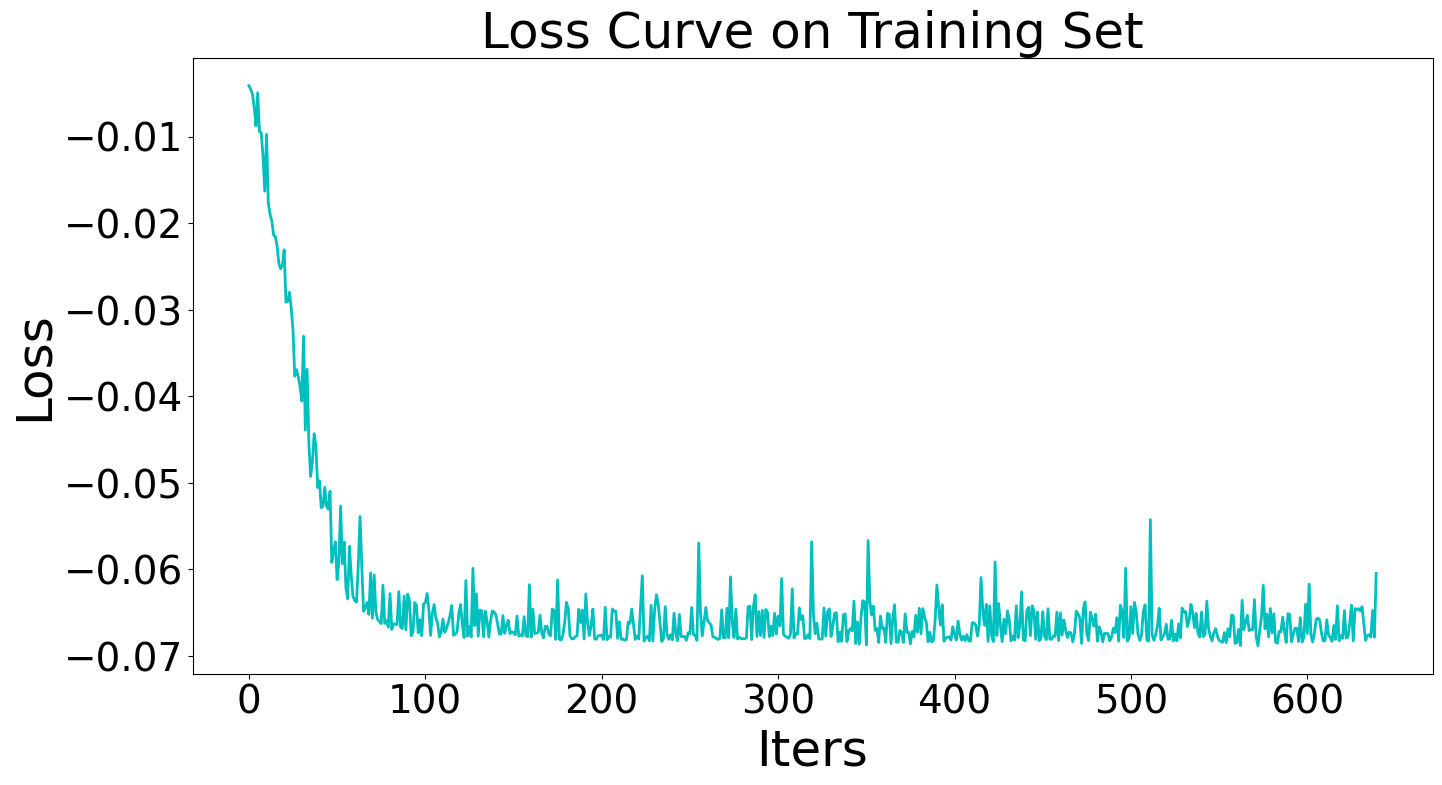

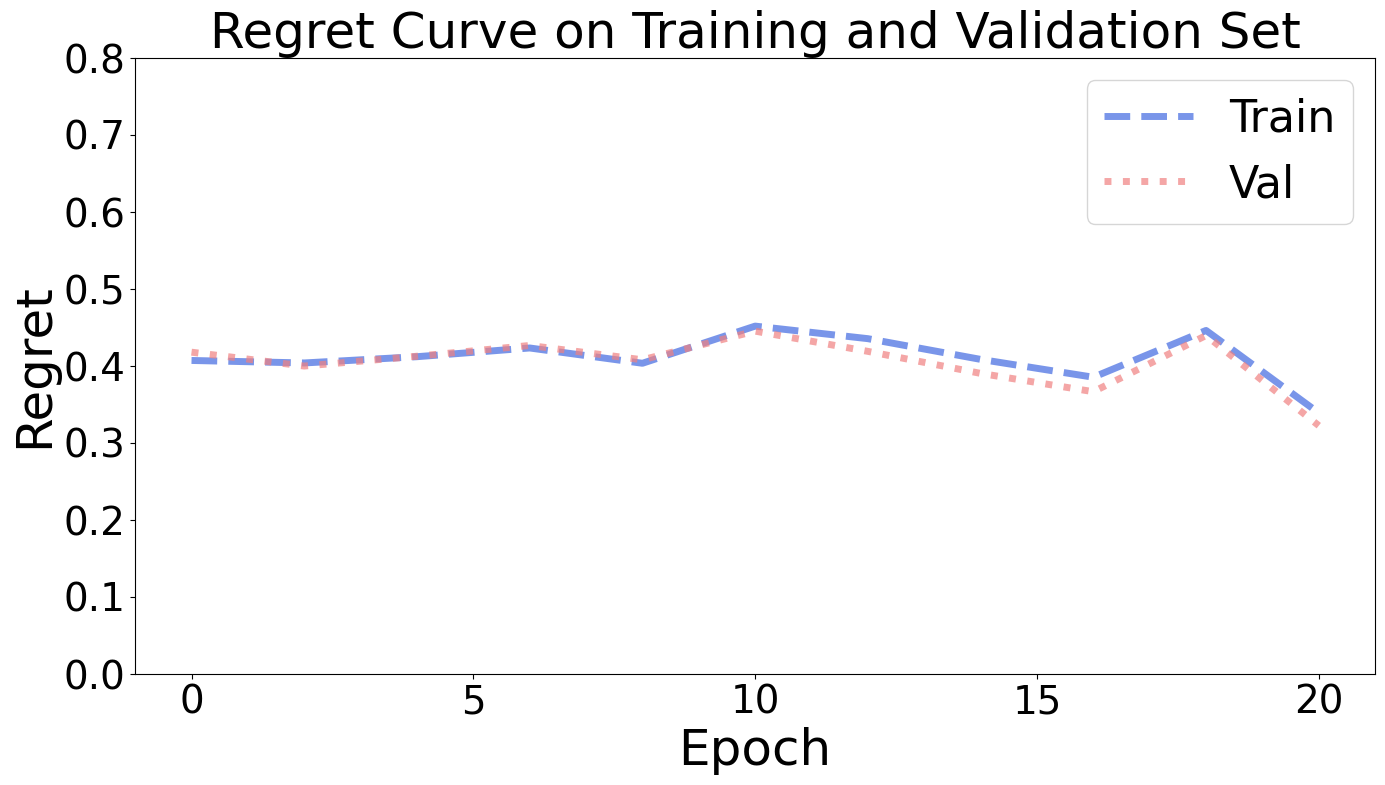

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [27]:
# init model
reg = LinearRegression()

In [28]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [29]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.5999, Train Regret:  10.3800%, Val Regret:  11.4701%
Epoch   2, Loss:  -0.7025, Train Regret:   2.3479%, Val Regret:   2.5158%
Epoch   4, Loss:  -0.6783, Train Regret:   2.3371%, Val Regret:   2.8633%
Epoch   6, Loss:  -0.6930, Train Regret:   2.3632%, Val Regret:   2.7258%
Epoch   8, Loss:  -0.6852, Train Regret:   2.5306%, Val Regret:   2.9806%
Epoch  10, Loss:  -0.7089, Train Regret:   2.5404%, Val Regret:   2.9098%
Epoch  12, Loss:  -0.7097, Train Regret:   2.5246%, Val Regret:   2.7291%
Epoch  14, Loss:  -0.7048, Train Regret:   2.3064%, Val Regret:   2.7161%
Epoch  16, Loss:  -0.6974, Train Regret:   2.4565%, Val Regret:   2.8469%
Epoch  18, Loss:  -0.6888, Train Regret:   2.4758%, Val Regret:   2.8193%
Elapsed Time: 5.29 Sec


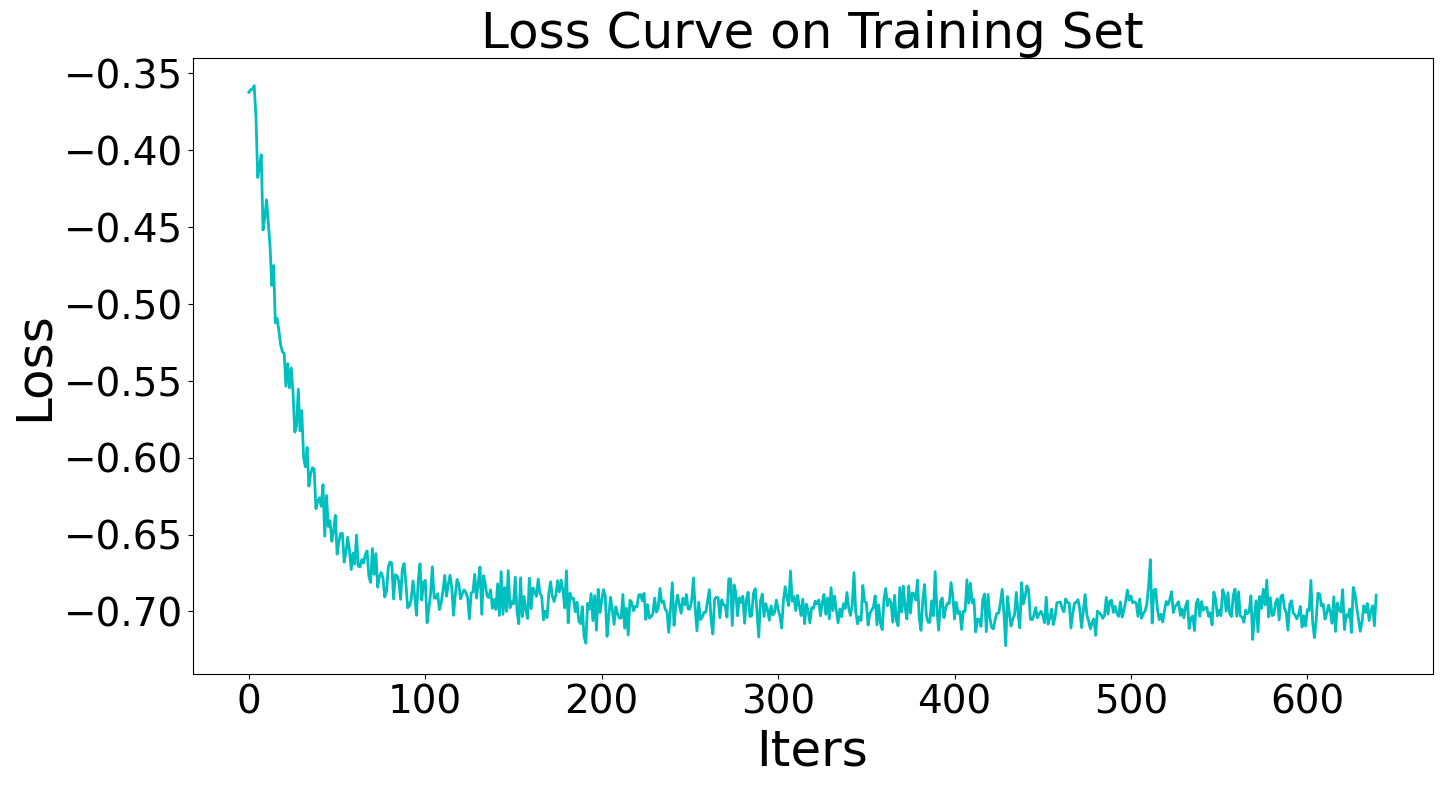

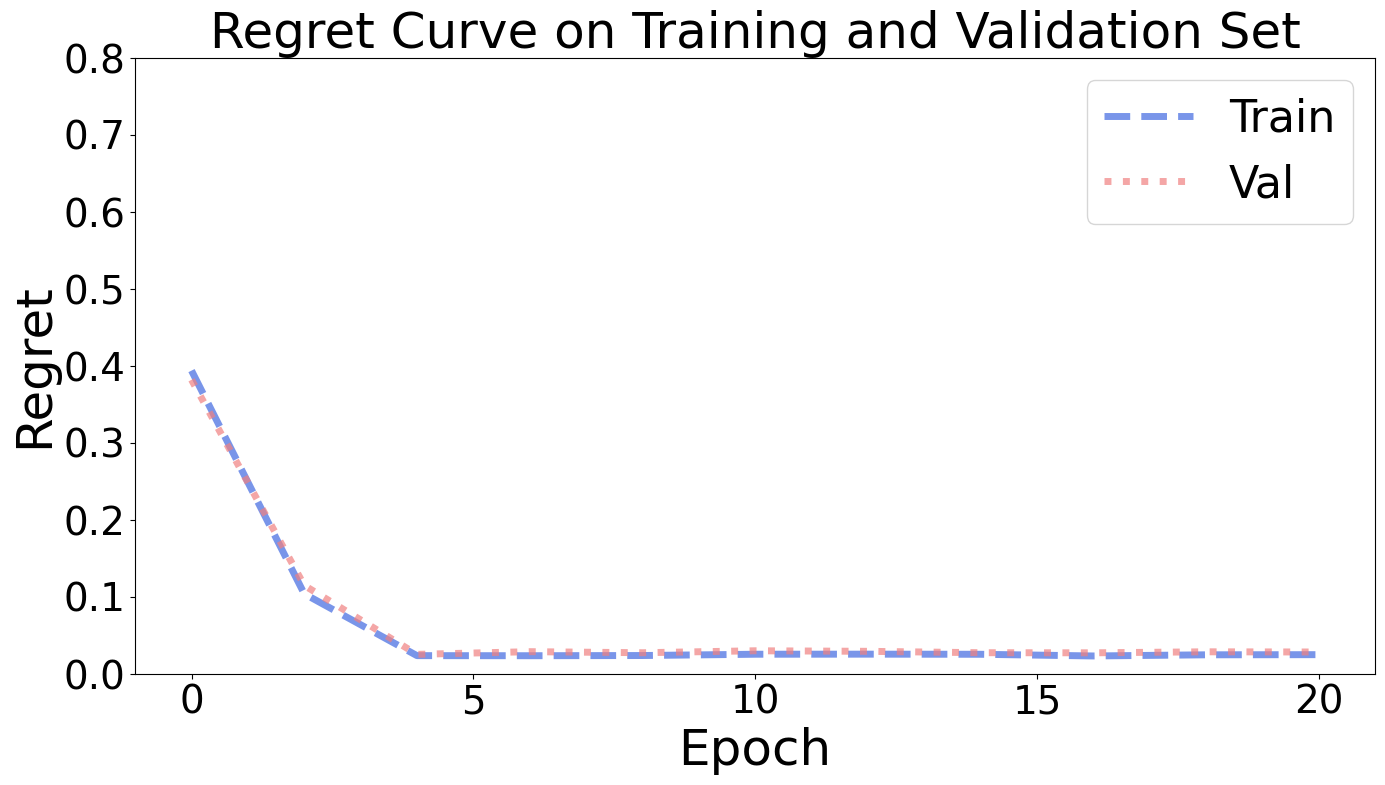

In [30]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method

In [31]:
# init model
reg = LinearRegression()

In [32]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [33]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9575, Train Regret:  12.7015%, Val Regret:  13.1093%
Epoch   2, Loss:  -0.9934, Train Regret:   3.2029%, Val Regret:   3.1345%
Epoch   4, Loss:  -0.9852, Train Regret:   2.1168%, Val Regret:   2.3709%
Epoch   6, Loss:  -0.9961, Train Regret:   2.0200%, Val Regret:   2.4597%
Epoch   8, Loss:  -0.9938, Train Regret:   2.2222%, Val Regret:   2.6432%
Epoch  10, Loss:  -0.9916, Train Regret:   2.2549%, Val Regret:   2.8169%
Epoch  12, Loss:  -0.9960, Train Regret:   2.5476%, Val Regret:   3.0285%
Epoch  14, Loss:  -0.9985, Train Regret:   2.7522%, Val Regret:   3.2637%
Epoch  16, Loss:  -0.9927, Train Regret:   2.9949%, Val Regret:   3.5015%
Epoch  18, Loss:  -0.9972, Train Regret:   3.3411%, Val Regret:   3.8615%
Elapsed Time: 6.36 Sec


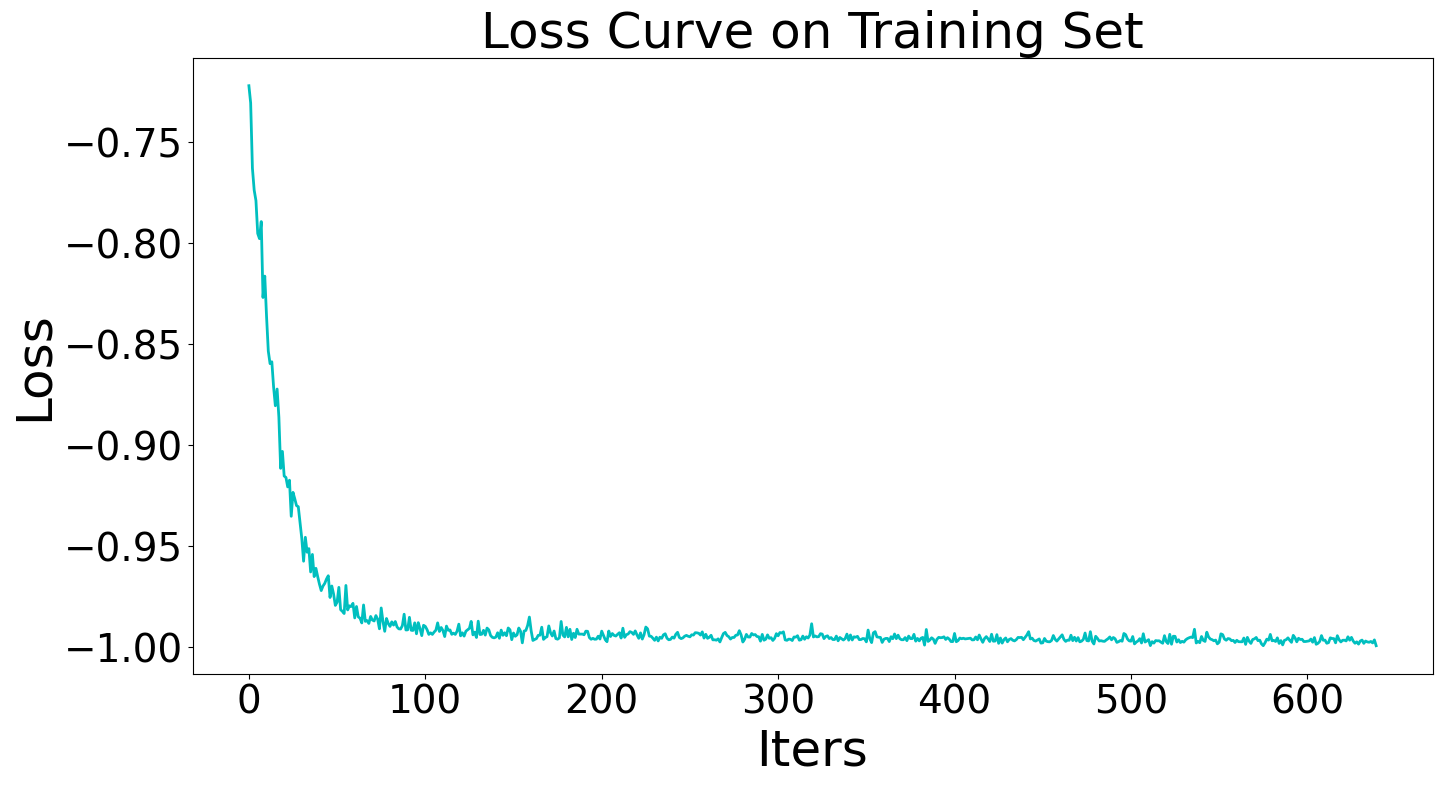

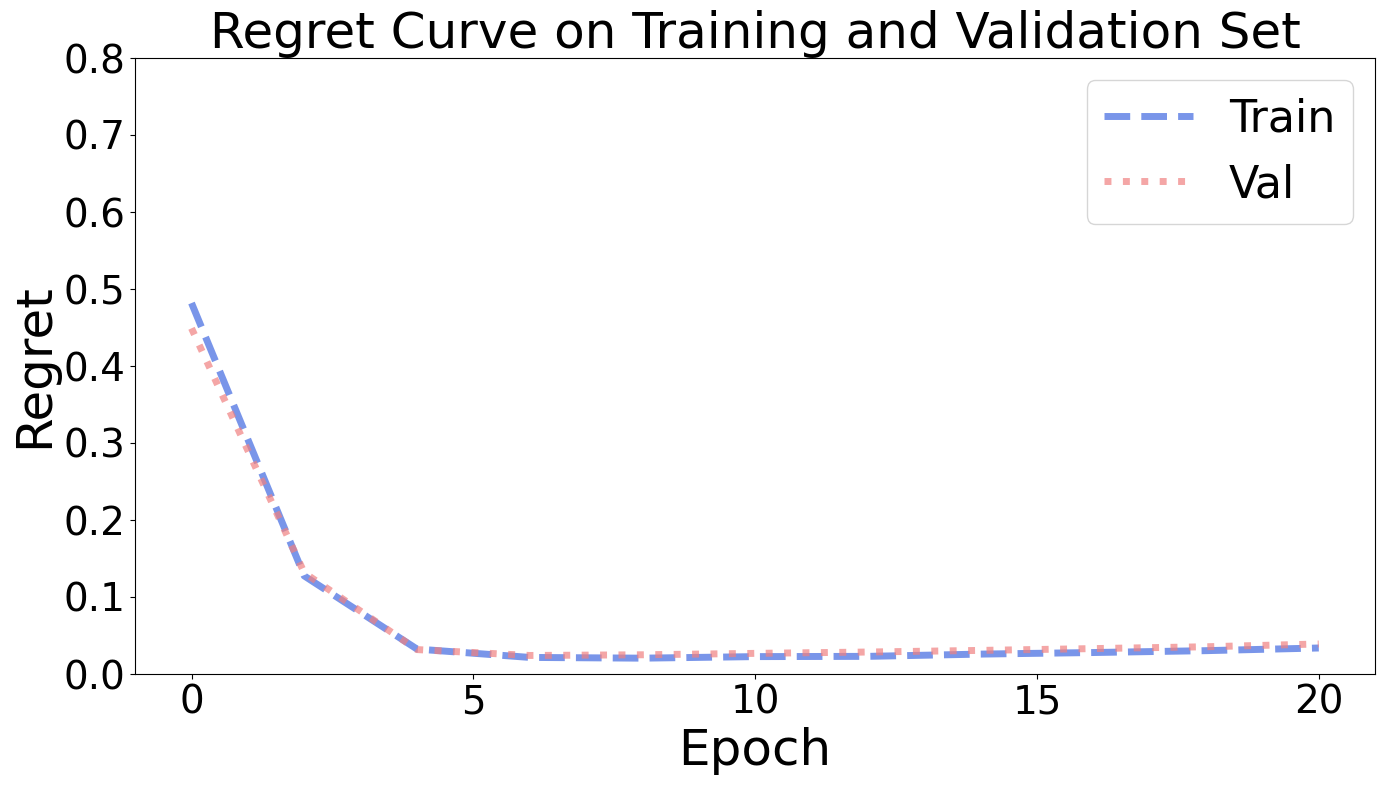

In [34]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)